# Mnist Drawing AI
## Version 1.0
Das Ziel dieser AI ist es einmal ein funktionierendes Environnment zu kreieren,
in der die KI lernen und arbeiten kann.

Hierbei soll wenigstens geschaut werden, ob die AI es erlernt mal nur ein Bild
zu zeichnen. In einer späteren Version sollen erst dann mehrere Bilder
hineingegeben werden.

Dabei soll als Input dienen:
- Ziel Bild 28x28 -> np.shape = (784,)
- States
    - Canvas State 28x28 -> np.shape = (784,)
    - Position von Agent in Space (Pen Position) -> np.shape(2,)

Dabei soll der Output sein:
- Integer
    - Es wird immer 1, 2, 3, 4 Gezählt, welches die Himmelsrichtungen darstellt.
    - Eine erhöhter Wert wird in den Stroke in die Länge gehen -> Bsp. 8 -> 2 Mal nach Links (Direction 4 und Length 2)

## Importing

In [1]:
import abc
import tensorflow as tf
import numpy as np
import random

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.environments import utils

import reverb

In [2]:
import matplotlib.pyplot as plt

In [3]:
from environnment import Canvas

## Env, Model and Agent Creation

### Load Dataset

In [4]:
from keras.datasets import mnist

In [5]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [6]:
env_py = Canvas(train_X[0])
env = tf_py_environment.TFPyEnvironment(env_py)

### Model

In [7]:
fc_layer_params = (100, 50) # Die Anzahl der Dense Units in einem Layer
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1
print("Num Actions: ", num_actions)

# Helper function um die Dense Layer zu kreeieren.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# Create the dense layer array
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]

# Create the output layer
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

# Sequentialize the layers into a tensorflow model
q_net = sequential.Sequential(dense_layers + [q_values_layer])

Num Actions:  16


### Agent

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

2022-04-18 22:43:08.358046: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (100)
2022-04-18 22:43:08.358097: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-ORA727V): /proc/driver/nvidia/version does not exist
2022-04-18 22:43:08.361368: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Random Metrics

In [9]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            total_return += episode_return

    avg_return = total_return / num_episodes
    env_py.render()
    return avg_return.numpy()[0]

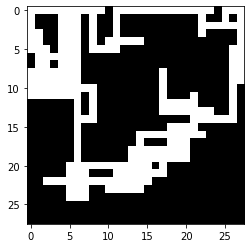

-1302705.2

In [10]:
compute_avg_return(env,
                   random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                   env.action_spec()),
                   10)

## Replay Buffer

In [11]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=100000,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:150]  Initializing TFRecordCheckpointer in /tmp/tmp_whxz40i.
[reverb/cc/platform/tfrecord_checkpointer.cc:386] Loading latest checkpoint from /tmp/tmp_whxz40i
[reverb/cc/platform/default/server.cc:71] Started replay server on port 22885


### Testing the replay buffer

In [12]:
py_driver.PyDriver(
    env_py,
    py_tf_eager_policy.PyTFEagerPolicy(
        random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                        env.action_spec()),
        use_tf_function=True),
        [rb_observer],
        max_steps=100
    ).run(env_py.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([ 0,  0,  0, ...,  0, 16, 18], dtype=int32),
  'reward': array(-42.1, dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [13]:
iter(replay_buffer.as_dataset()).next()

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3325) so Table uniform_table is accessed directly without gRPC.


(Trajectory(
 {'action': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([15,  5], dtype=int32)>,
  'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>,
  'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
  'observation': <tf.Tensor: shape=(2, 1570), dtype=int32, numpy=
 array([[ 0,  0,  0, ...,  0, 11, 18],
        [ 0,  0,  0, ...,  0, 11, 14]], dtype=int32)>,
  'policy_info': (),
  'reward': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-66.3, -66.3], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>}),
 SampleInfo(key=<tf.Tensor: shape=(2,), dtype=uint64, numpy=array([15661501847674301771, 15661501847674301771], dtype=uint64)>, probability=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.01030928, 0.01030928])>, table_size=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([97, 97])>, priority=<tf.Tensor: shape=(2,), dtype=float64, numpy=array(

In [14]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=64,
    num_steps=2).prefetch(3)
iterator = iter(dataset)

In [15]:
iterator = iter(dataset)
print(iterator)

In [16]:
next(iterator)

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3325) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3325) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3325) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3325) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (3325) so Table uniform_table is accessed directly without gRPC.


(Trajectory(
 {'action': <tf.Tensor: shape=(64, 2), dtype=int32, numpy=
 array([[ 4, 12],
        [ 5, 15],
        [10, 13],
        [ 5,  5],
        [ 5,  4],
        [12,  9],
        [ 2,  7],
        [ 1,  5],
        [ 8,  2],
        [ 8,  5],
        [ 8,  8],
        [14,  2],
        [13,  1],
        [ 9, 10],
        [ 7,  8],
        [ 4,  1],
        [ 4,  5],
        [ 9,  7],
        [ 2,  9],
        [ 1,  4],
        [ 1, 10],
        [ 0, 13],
        [ 2,  6],
        [15, 10],
        [ 4,  8],
        [ 4, 13],
        [ 8, 11],
        [ 9,  7],
        [ 5, 15],
        [12, 15],
        [10,  7],
        [ 9,  0],
        [ 0, 15],
        [13,  1],
        [14,  5],
        [ 8, 11],
        [ 9,  9],
        [ 4, 13],
        [ 9,  6],
        [ 7,  6],
        [ 8, 11],
        [ 3,  9],
        [ 1,  5],
        [ 5, 15],
        [ 8, 14],
        [ 2,  6],
        [14,  2],
        [ 5,  7],
        [10, 13],
        [ 1,  0],
        [12,  9],
        [1

## AI Training

In [17]:
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=0>

In [18]:
time_step = env_py.reset()

In [19]:
# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env_py,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=1)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 10: loss = 1299.494384765625
step = 20: loss = 1506.533447265625
step = 30: loss = 1569.289794921875
step = 40: loss = 913.06103515625
step = 50: loss = 1938.482421875
step = 60: loss = 1958.738037109375
step = 70: loss = 11026.2509765625
step = 80: loss = 1359.4161376953125
step = 90: loss = 613.1393432617188
step = 100: loss = 4066.4443359375
step = 110: loss = 5394.06005859375
step = 120: loss = 2316.4443359375
step = 130: loss = 1331.09619140625
step = 140: loss = 2075.090576171875
step = 150: loss = 1405.6241455078125
step = 160: loss = 2072.765869140625
step = 170: loss = 4640.81591796875
step = 180: loss = 1919.7119140625
step = 190: loss = 2662.873046875
step = 200: loss = 1487.014404296875
step = 210: loss = 11496.451171875
step = 220: loss

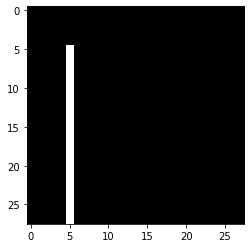

step = 500: Average Return = -1533367.25
step = 510: loss = 2044.905517578125
step = 520: loss = 1907.539306640625
step = 530: loss = 5481.650390625
step = 540: loss = 1445.697998046875
step = 550: loss = 889.5955810546875
step = 560: loss = 1612.354736328125
step = 570: loss = 3577.86376953125
step = 580: loss = 1844.1783447265625
step = 590: loss = 1922.6549072265625
step = 600: loss = 12853.25
step = 610: loss = 1719.8623046875
step = 620: loss = 2488.4462890625
step = 630: loss = 2578.5205078125
step = 640: loss = 1706.629638671875
step = 650: loss = 1458.222412109375
step = 660: loss = 5810.69384765625
step = 670: loss = 1540.43212890625
step = 680: loss = 1552.7593994140625
step = 690: loss = 2032.8114013671875
step = 700: loss = 2865.75
step = 710: loss = 2586.50048828125
step = 720: loss = 3942.99462890625
step = 730: loss = 1332.861572265625
step = 740: loss = 1269.001953125
step = 750: loss = 671.4451293945312
step = 760: loss = 2366.740234375
step = 770: loss = 1655.27929687

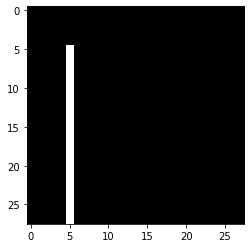

step = 1000: Average Return = -1539408.75


In [20]:
returns = []
for _ in range(1000):
    
  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % 10 == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % 500 == 0:
    avg_return = compute_avg_return(env, agent.policy, 10)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)